## Import libraries

In [1]:
# system and performance
import gc
import time
import os
import pickle


# date management
import datetime
import calendar


# data management
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

from itertools import product

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# machine learning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print('directory '+path+' created succesfully !')
    else:
        print('directory '+path+' already exists')

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
# path to data
RAW_DATA_FOLDER = '../data/raw/'
DATA_FOLDER = '../data/'

##### Define core variable space and macro to reset variable space

In [5]:
loaded=%who_ls
loaded.append('loaded')

In [6]:
all_vars=%who_ls
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var

In [7]:
%macro reset_variable_space 6
loaded.append('reset_variable_space')

Macro `reset_variable_space` created. To execute, type its name (without quotes).
=== Macro contents: ===
all_vars=get_ipython().run_line_magic('who_ls', '')
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var
 

## -------------------------------------------------------------

# 6 - TRAINING FOR PREDICTION

## Functions for training and validation

In [8]:
# SPLIT TRAIN-TEST SET
def datasplit_train_test(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    # TRAINING SET
    X_train=train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),:].astype(np.float32)
    Y_train=X_train['item_quantity'].astype(np.float32)
    X_train.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_train.shape, Y_train.shape)

    # TEST SET
    X_test=train_df.loc[train_df['month_id']==34,:].astype(np.float32)
    X_test.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_test.shape)

    return (X_train,Y_train,X_test)





# SPLIT TRAINING SET MONTH BY MONTH
def datasplit_evalset(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    eval_set=[]
    for mid in train_df['month_id'].unique():
        if (mid>=month_id_first)&(mid<34):
            X_val=train_df.loc[(train_df['month_id']==mid),:].astype(np.float32)
            Y_val=X_val['item_quantity'].astype(np.float32)
            X_val.drop(['month_id','item_quantity'],axis=1,inplace=True)
            eval_set.append((X_val,Y_val))
        
    return eval_set

In [9]:
# ANALYSIS OF TARGET VALUE AND NAIVE PREDICTIONS
def target_analysis_test(train_df,month_id_first=0):

    # split dataset
    (X_train,Y_train,_) = datasplit_train_test(train_df,month_id_first)
    evalset = datasplit_evalset(train_df,month_id_first)

    # BASE SCORE
    base_score=Y_train.mean()
    base_score_evalset=[Y.mean() for (_,Y) in evalset]

    # BENCHMARK (guess with 0 everywhere)
    Y_guess_train=0*Y_train
    rmse_guess_train=np.sqrt(mean_squared_error(Y_train, Y_guess_train))

    Y_base_train=0*Y_train+base_score
    rmse_base_train=np.sqrt(mean_squared_error(Y_train, Y_base_train))

    print('#### TRAINING SET ###')
    print('mean target value: '+str(base_score))
    print('RMSE (guess,base): '+str(rmse_guess_train)+' , '+str(rmse_base_train))

    rmse_guess_evalset=[]
    rmse_base_evalset=[]
    for (_,Y) in evalset:
        Y_guess=0*Y
        rmse_guess_evalset.append(np.sqrt(mean_squared_error(Y, Y_guess)))

        Y_base=0*Y+Y.mean()
        rmse_base_evalset.append(np.sqrt(mean_squared_error(Y, Y_base)))

    print('#### EVAL SET ###')
    print('mean target value: '+str([round(b*1e4)/1e4 for b in base_score_evalset]))
    print('RMSE (guess): '+str([round(b*1e2)/1e2 for b in rmse_guess_evalset]))
    print('RMSE (base): '+str([round(b*1e2)/1e2 for b in rmse_base_evalset]))

    fig,axes=plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),base_score_evalset,'-o')
    axes[0].set_xlabel('month_id')
    axes[0].set_ylabel('mean of target value')
    axes[0].grid(True)
    axes[0].set_ylim(bottom=0)

    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_guess_evalset,'-o')
    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_base_evalset,'-o')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse')
    axes[1].legend(['guess = 0','mean value'])
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)
    
    return rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset

In [10]:
# PERFORMANCES ON TRAINING SET
def performance_analysis_test(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_evalset,rmse_base_evalset):

    rmse_evalset_last=[]
    rmse_evalset_min=[]
    for evset in xgbreg.evals_result().values():
        rmse_evalset_last.append(evset['rmse'][-1])
        rmse_evalset_min.append(min(evset['rmse']))

    # display
    print('#### TRAINING SET ###')
    print('RMSE (last, min, base, guess): '+str(rmse_evalset_last[0]) +' , '+str(rmse_evalset_min[0])+' , '+str(rmse_base_train)+' , '+str(rmse_guess_train))
    print()
    print('#### EVAL SET ###')
    print('RMSE (last): '+str([round(b*1e4)/1e4 for b in rmse_evalset_last[1:]]))
    print('RMSE (min): '+str([round(b*1e4)/1e4 for b in rmse_evalset_min[1:]]))
    print('RMSE (base): '+str([round(b*1e4)/1e4 for b in rmse_base_evalset]))
    print('RMSE (guess): '+str([round(b*1e4)/1e4 for b in rmse_guess_evalset]))


    fig,axes=plt.subplots(1,2,figsize=(15,5))
    for i in range(1,len(xgbreg.evals_result())):
        evset=xgbreg.evals_result()['validation_'+str(i)]['rmse']
        axes[0].plot(evset,'-o')
    axes[0].legend(range(0,len(eval_set)))
    axes[0].plot(xgbreg.evals_result()['validation_0']['rmse'],'k',linewidth=5)


    axes[1].plot(rmse_evalset_last[1:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_last[1:])+rmse_evalset_last[0],'k')
    axes[1].plot(rmse_evalset_min[1:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_min[1:])+rmse_evalset_last[0],'r')
    axes[1].plot(rmse_guess_evalset,'k-s')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse (last,min)')
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)

In [11]:
# FEATURE IMPORTANCE
def plot_feature_importance(xgbreg,X_train):
    # gain     := improvement in accuracy resulting from a split according to this feature (measured by a reduction of the optimization metric)
    # weight   := number of times a feature is used to split the data across all trees
    # coverage := number of observations that are classified according to this feature in the tree

    n_features=len(X_train.columns)
    
    fi_types=[ 'total_gain' , 'gain', 'weight', 'cover' , 'total_cover']
    xgb_fi=pd.DataFrame(index=X_train.columns)
    for typ in fi_types:
        xgb_fi[typ]=pd.Series(data=xgbreg.get_booster().get_score(importance_type=typ),index=X_train.columns)

    xgb_fi.fillna(0,inplace=True)
    xgb_fi=xgb_fi.sort_values(by='gain',ascending=True)

    fig,ax=plt.subplots(1,5,figsize=(18,np.floor(n_features/2.5)))
    for i,typ in enumerate(fi_types[0:5]):
        if i==0:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values)
        else:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values,tick_label=[None])
        ax[i].grid(True)
        ax[i].set_title(typ)

In [12]:
loaded=%who_ls
loaded.append('loaded')

## ----------------------------------------------

In [13]:
# create directories
create_directory(os.path.join(DATA_FOLDER, 'predictions'))
create_directory(os.path.join(DATA_FOLDER, 'predictions/models/'))

directory ../data/predictions already exists
directory ../data/predictions/models/ already exists


## SENIORITY 1

### Import and process training set

In [14]:
dataset_name='train_1_pred'
month_id_first=18

train_X=pd.read_pickle(os.path.join(DATA_FOLDER,'training/'+dataset_name+'.pkl'))

print(train_X.info(null_counts=True,verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2609643 entries, 4458648 to 10844087
Data columns (total 102 columns):
month_id                                                                            2609643 non-null int8
item_category_id                                                                    2609643 non-null int8
item_quantity                                                                       2609643 non-null float32
shop_months_since_opening                                                           2609643 non-null int8
shop_opening                                                                        2609643 non-null bool
item_freq_in_seniority                                                              2609643 non-null float32
item_category_freq                                                                  2609643 non-null float32
item_supercategory_freq                                                             2609643 non-null float32
item_category_conso

(1672855, 100) (1672855,)
(86603, 100)
#### TRAINING SET ###
mean target value: 0.05297470465302467
RMSE (guess,base): 0.36200446 , 0.3581073893464452
#### EVAL SET ###
mean target value: [0.0522, 0.0501, 0.0379, 0.0491, 0.0527, 0.0997, 0.0505, 0.048, 0.0416, 0.0445, 0.0474, 0.0479, 0.0563, 0.058, 0.0479, 0.0541]
RMSE (guess): [0.35, 0.35, 0.25, 0.4, 0.35, 0.6, 0.34, 0.37, 0.3, 0.29, 0.32, 0.31, 0.34, 0.36, 0.32, 0.34]
RMSE (base): [0.35, 0.34, 0.25, 0.4, 0.34, 0.59, 0.33, 0.37, 0.3, 0.29, 0.32, 0.31, 0.34, 0.36, 0.32, 0.33]


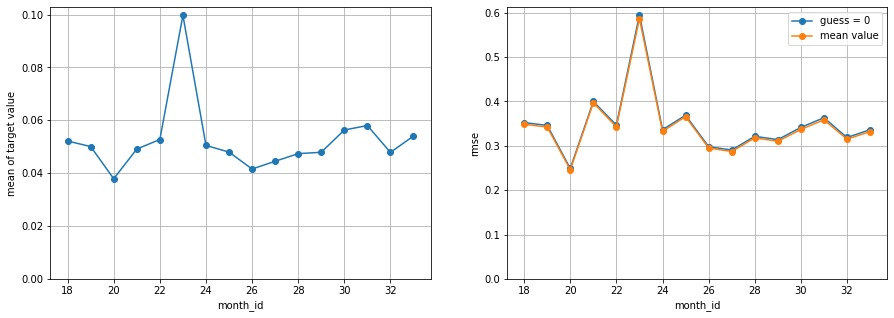

In [15]:
# analyse dataset
rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset = target_analysis_test(train_X,month_id_first=18)

In [16]:
features_to_keep_1=[]

#--------------
# CATEGORY
features_to_keep_1+=['item_category_id']                                     

features_to_keep_1+=['item_category_freq']                                   
features_to_keep_1+=['item_supercategory_freq']                              
features_to_keep_1+=['item_category_console_freq']                            
features_to_keep_1+=['item_category_digital_freq']

#features_to_keep_1+=['item_category_freq_in_seniority']
#features_to_keep_1+=['item_supercategory_freq_in_seniority']
#features_to_keep_1+=['item_category_console_freq_in_seniority']
#features_to_keep_1+=['item_category_digital_freq_in_seniority']

#features_to_keep_1+=['category_semiannual_avg_recent_rsd']
#features_to_keep_1+=['category_semiannual_avg_annual_rsd']


#--------------
# SHOP
features_to_keep_1+=['shop_months_since_opening']
features_to_keep_1+=['shop_opening']

#--------------
# ITEM
features_to_keep_1+=['item_freq_in_seniority']

#--------------
# RELATIVE TIME FEATURES
features_to_keep_1+=['item_months_since_release']










#--------------
# PRICES

features_to_keep_1+=['item_price_median_absolute_mean']                
features_to_keep_1+=['item_price_median_last_sale']                    
features_to_keep_1+=['item_price_min_absolute_min']                    
features_to_keep_1+=['item_price_max_absolute_max']                    

#features_to_keep_1+=['item_price_median_compared_to_category_price_median_absolute_mean']                
#features_to_keep_1+=['item_price_median_compared_to_category_price_median_last_sale']                    

features_to_keep_1+=['category_price_median_recent_mean']                    










#--------------
# ITEM
features_to_keep_1+=['item_max_quantity_absolute_max'] 

#features_to_keep_1+=['item_avg_sales_absolute_mean']
#features_to_keep_1+=['item_avg_sales_annual_mean']
#features_to_keep_1+=['item_avg_sales_semiannual_mean']
features_to_keep_1+=['item_avg_sales_recent_mean']                
features_to_keep_1+=['item_avg_sales_lag_1']                        
#features_to_keep_1+=['item_avg_sales_lag_12']
features_to_keep_1+=['item_avg_sales_last_sale']                   


#features_to_keep_1+=['item_avg_sales_over_sold_absolute_mean']
#features_to_keep_1+=['item_avg_sales_over_sold_annual_mean']
#features_to_keep_1+=['item_avg_sales_over_sold_semiannual_mean']
features_to_keep_1+=['item_avg_sales_over_sold_recent_mean']                  
features_to_keep_1+=['item_avg_sales_over_sold_lag_1']                        
#features_to_keep_1+=['item_avg_sales_over_sold_lag_12']                         
features_to_keep_1+=['item_avg_sales_over_sold_last_sale']                    


#features_to_keep_1+=['item_avg_sales_seniority_1_absolute_mean']
#features_to_keep_1+=['item_avg_sales_seniority_1_annual_mean']
#features_to_keep_1+=['item_avg_sales_seniority_1_semiannual_mean']
features_to_keep_1+=['item_avg_sales_seniority_1_recent_mean']
features_to_keep_1+=['item_avg_sales_seniority_1_lag_1']
#features_to_keep_1+=['item_avg_sales_seniority_1_lag_12']
features_to_keep_1+=['item_avg_sales_seniority_1_last_sale']



#--------------
# SHOP
#features_to_keep_1+=['shop_avg_sales_seniority_1_absolute_mean']
#features_to_keep_1+=['shop_avg_sales_seniority_1_annual_mean']
#features_to_keep_1+=['shop_avg_sales_seniority_1_semiannual_mean']
#features_to_keep_1+=['shop_avg_sales_seniority_1_recent_mean']
#features_to_keep_1+=['shop_avg_sales_seniority_1_lag_1']
features_to_keep_1+=['shop_avg_sales_seniority_1_lag_12']                                                     

#features_to_keep_1+=['shop_avg_sales_absolute_mean']
#features_to_keep_1+=['shop_avg_sales_annual_mean']
#features_to_keep_1+=['shop_avg_sales_semiannual_mean']
#features_to_keep_1+=['shop_avg_sales_recent_mean']
#features_to_keep_1+=['shop_avg_sales_lag_1']                                                                          
features_to_keep_1+=['shop_avg_sales_lag_12']                                                                         



#--------------
# MONTHS SINCE RELEASE
features_to_keep_1+=['category_months_since_release_avg_sales_seniority_1_absolute_mean']                       
features_to_keep_1+=['category_months_since_release_avg_sales_seniority_1_annual_mean']
#features_to_keep_1+=['category_months_since_release_avg_sales_seniority_1_semiannual_mean']
features_to_keep_1+=['category_months_since_release_avg_sales_seniority_1_recent_mean']               
#features_to_keep_1+=['category_months_since_release_avg_sales_seniority_1_lag_1']
features_to_keep_1+=['category_months_since_release_avg_sales_seniority_1_lag_12']                   

features_to_keep_1+=['shop_category_months_since_release_avg_sales_seniority_1_absolute_mean']                        
features_to_keep_1+=['shop_category_months_since_release_avg_sales_seniority_1_annual_mean'] 
#features_to_keep_1+=['shop_category_months_since_release_avg_sales_seniority_1_semiannual_mean']
features_to_keep_1+=['shop_category_months_since_release_avg_sales_seniority_1_recent_mean']                         
#features_to_keep_1+=['shop_category_months_since_release_avg_sales_seniority_1_lag_1']               
features_to_keep_1+=['shop_category_months_since_release_avg_sales_seniority_1_lag_12']                                 

features_to_keep_1+=['supercategory_months_since_release_avg_sales_seniority_1_absolute_mean']
features_to_keep_1+=['supercategory_months_since_release_avg_sales_seniority_1_annual_mean']
#features_to_keep_1+=['supercategory_months_since_release_avg_sales_seniority_1_semiannual_mean']
features_to_keep_1+=['supercategory_months_since_release_avg_sales_seniority_1_recent_mean']
#features_to_keep_1+=['supercategory_months_since_release_avg_sales_seniority_1_lag_1']
features_to_keep_1+=['supercategory_months_since_release_avg_sales_seniority_1_lag_12']                                

features_to_keep_1+=['shop_supercategory_months_since_release_avg_sales_seniority_1_absolute_mean']
features_to_keep_1+=['shop_supercategory_months_since_release_avg_sales_seniority_1_annual_mean']
#features_to_keep_1+=['shop_supercategory_months_since_release_avg_sales_seniority_1_semiannual_mean']
features_to_keep_1+=['shop_supercategory_months_since_release_avg_sales_seniority_1_recent_mean']
#features_to_keep_1+=['shop_supercategory_months_since_release_avg_sales_seniority_1_lag_1']
features_to_keep_1+=['shop_supercategory_months_since_release_avg_sales_seniority_1_lag_12']                         



#--------------
# SPATIAL TRENDS
#features_to_keep_1+=['shop_category_avg_sales_compared_to_category_absolute_mean']
features_to_keep_1+=['shop_category_avg_sales_compared_to_category_annual_mean']               
#features_to_keep_1+=['shop_category_avg_sales_compared_to_category_semiannual_mean']
features_to_keep_1+=['shop_category_avg_sales_compared_to_category_recent_mean']              
features_to_keep_1+=['shop_category_avg_sales_compared_to_category_lag_1']                    
features_to_keep_1+=['shop_category_avg_sales_compared_to_category_lag_12']                    


# TEMPORAL TRENDS
#features_to_keep_1+=['shop_avg_sales_compare_recent_mean_to_annual_mean']
#features_to_keep_1+=['shop_avg_sales_compare_lag1_to_annual_mean']                              
features_to_keep_1+=['shop_avg_sales_compare_lag12_to_annual_mean']                               

features_to_keep_1+=['supercategory_avg_sales_compare_recent_mean_to_annual_mean']        
#features_to_keep_1+=['supercategory_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_1+=['supercategory_avg_sales_compare_lag12_to_annual_mean']              

features_to_keep_1+=['category_avg_sales_compare_recent_mean_to_annual_mean']               
#features_to_keep_1+=['category_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_1+=['category_avg_sales_compare_lag12_to_annual_mean']                     

features_to_keep_1+=['category_avg_sales_compared_to_supercategory_recent_mean']          
#features_to_keep_1+=['category_avg_sales_compared_to_supercategory_lag_1']                
features_to_keep_1+=['category_avg_sales_compared_to_supercategory_lag_12']                    


# MONTH OF RELEASE
features_to_keep_1+=['supercategory_month_of_release_avg_sales_compared_to_supercategory_absolute_mean']         
features_to_keep_1+=['category_month_of_release_avg_sales_compared_to_category_absolute_mean']                  

In [17]:
# drop features
features_to_discard_1=list( set(list(train_X.columns)) - set(['month_id','item_quantity']+features_to_keep_1) )
train_X.drop(features_to_discard_1,axis=1,inplace=True)

# fill missing values
train_X.fillna(-1,inplace=True)

# split dataset
(X_train,Y_train,X_test) = datasplit_train_test(train_X,month_id_first)
eval_set = [(X_train,Y_train)]+datasplit_evalset(train_X,month_id_first)

# show dataset info
print('number of features to keep : '+str(len(features_to_keep_1)))
print('number of features kept    : '+str(len(X_train.columns)))

print(X_train.info(null_counts=True,verbose=True))


# clear memory space
del train_X
gc.collect()

(1672855, 55) (1672855,)
(86603, 55)
number of features to keep : 55
number of features kept    : 55
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1672855 entries, 6437785 to 10683865
Data columns (total 55 columns):
item_category_id                                                                    1672855 non-null float32
shop_months_since_opening                                                           1672855 non-null float32
shop_opening                                                                        1672855 non-null float32
item_freq_in_seniority                                                              1672855 non-null float32
item_category_freq                                                                  1672855 non-null float32
item_supercategory_freq                                                             1672855 non-null float32
item_category_console_freq                                                          1672855 non-null float32
item_category_di

5378

### XGBRegressor - training for predictions

In [18]:
# SET XGBOOST PARAMETERS

xgb_params_1={'objective':        'reg:squarederror',
# TREE SPECIFIC PARAMETERS
              'max_depth':        5,
              'min_child_weight': 1e3,
              'subsample':        0.8,
              'colsample_bytree': 0.8,
# PARAMETERS RELATED TO THE LEARNING/BOOSTING PROCESS
              'learning_rate':    0.05,
              'n_estimators':     500,  
# MISCELLANEOUS PARAMETERS
              'base_score':       0.05,
              'n_jobs':           4,
              'random_state':     2
             }


# restrict clipping range for training data
# for seniority 1, we observed that target values larger than 8 are so rare that they may be considered noise
# clipping target values to 6 acts as a filter that improves the overall prediction on that class of samples
Y_train.clip(0,6,inplace=True)



# FIT MODEL
ts=time.time()

xgbreg=XGBRegressor(**xgb_params_1)
xgbreg.fit(X_train,Y_train,eval_set=eval_set,eval_metric='rmse',verbose=False)

print(time.time()-ts)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


2150.7819418907166


#### TRAINING SET ###
RMSE (last, min, base, guess): 0.262009 , 0.262009 , 0.3581073893464452 , 0.36200446

#### EVAL SET ###
RMSE (last): [0.301, 0.2998, 0.2224, 0.3477, 0.3, 0.4874, 0.2949, 0.3208, 0.2498, 0.2526, 0.2821, 0.2644, 0.2906, 0.3037, 0.2791, 0.2915]
RMSE (min): [0.301, 0.2998, 0.2224, 0.3477, 0.3, 0.4874, 0.2949, 0.3208, 0.2498, 0.2526, 0.2821, 0.2644, 0.2906, 0.3037, 0.2791, 0.2915]
RMSE (base): [0.3485, 0.3424, 0.2461, 0.397, 0.3427, 0.5869, 0.3324, 0.3659, 0.2951, 0.2871, 0.3179, 0.3103, 0.3368, 0.3587, 0.3152, 0.3319]
RMSE (guess): [0.3524, 0.346, 0.249, 0.4, 0.3468, 0.5953, 0.3363, 0.369, 0.2981, 0.2906, 0.3214, 0.314, 0.3415, 0.3634, 0.3188, 0.3363]


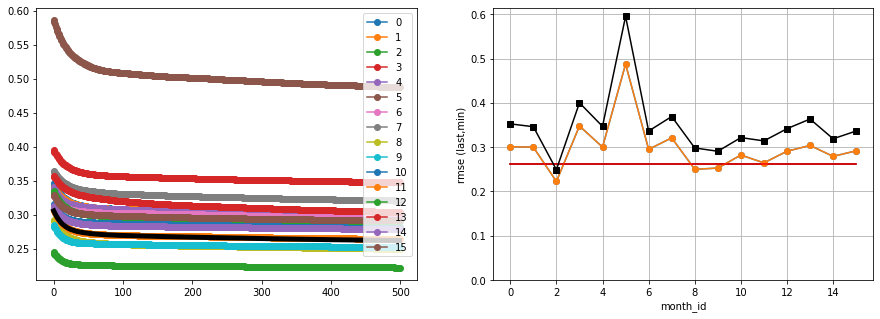

In [19]:
# PERFORMANCE ANALYSIS
performance_analysis_test(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_evalset,rmse_base_evalset)

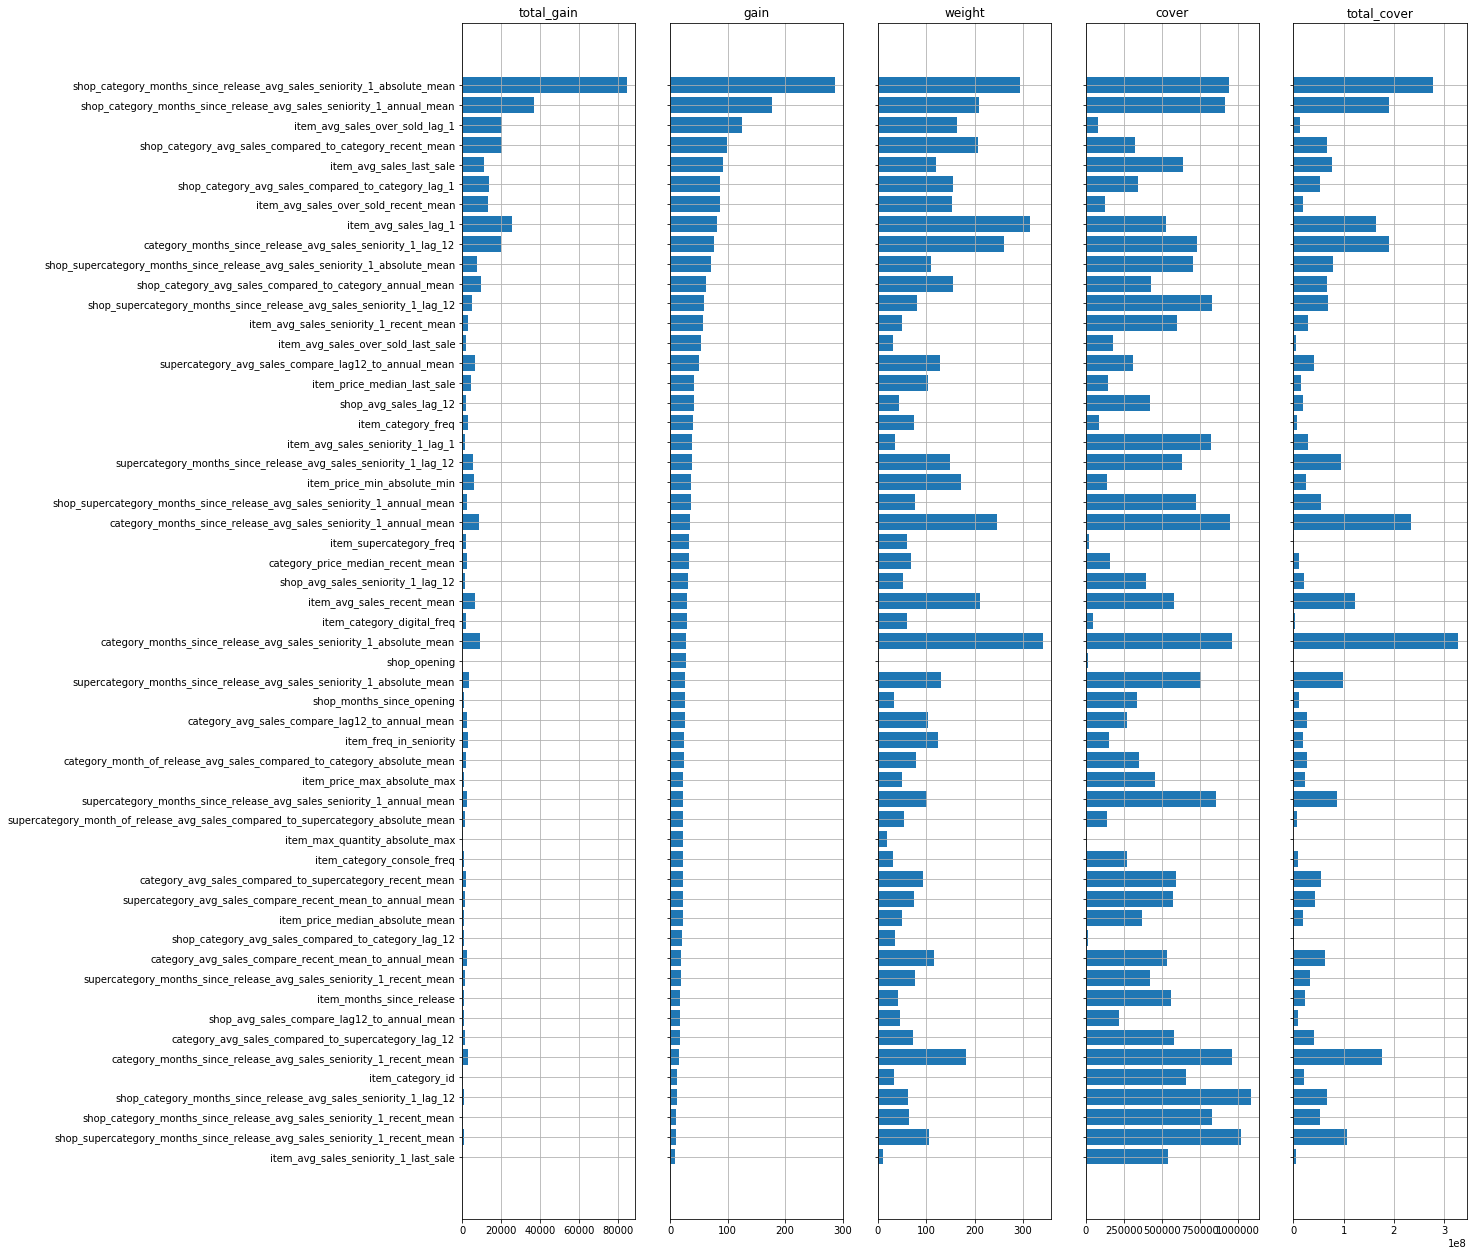

In [20]:
# FEATURE IMPORTANCE
plot_feature_importance(xgbreg,X_train)

### Save model and test set

In [21]:
# create directory
create_directory(os.path.join(DATA_FOLDER, 'predictions/models/xgbreg_seniority1'))

# export model
pickle.dump(xgbreg, open(os.path.join(DATA_FOLDER,'predictions/models/xgbreg_seniority1/model.pickle'), 'wb'))
X_test.to_pickle(os.path.join(DATA_FOLDER,'predictions/models/xgbreg_seniority1/X_test.pkl'))

directory ../data/predictions/models/xgbreg_seniority1 created succesfully !


In [22]:
# clear memory
del X_train, Y_train, X_test
del eval_set
del rmse_guess_train, rmse_base_train, rmse_guess_evalset, rmse_base_evalset
del xgbreg

gc.collect()

53175

In [23]:
reset_variable_space